In [1]:
### Simulation parameters
n_donors = 2
n_conditions = 3
n_cells_per_donor_cond = 300
n_clones_in_don = 5
n_positions = 100
n_variants_per_clone_lambda = 1
n_donor_variants = 10

seq_error = 0.01
don_var_lim=(0.8,1)
clone_var_lim=(0.1,0.4)
depth_lim = (4,10)
chars = ["A", "G", "C", "T"]

outdir = "/data/Mito_Trace/output/clone_pileups_simulation/"

ref_fa = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

dirs = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/Control/MT/cellr_True/numread_200/"



In [2]:
from Bio import SeqIO

import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join, exists
import os
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline
import mplh.cluster_help as ch

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16)


In [5]:
params = {"donors":n_donors,"conditions":n_conditions, "cells_per_donor_cond":n_cells_per_donor_cond,
         "clones_in_don":n_clones_in_don, "positions":n_positions, 
          "variants_per_clone_lambda":n_variants_per_clone_lambda, "donor_variants":n_donor_variants}


seq_params = {"seq_error": seq_error, "don_var_lim":"_".join(np.array(don_var_lim).astype(str)), 
              "clone_var_lim": "_".join(np.array(clone_var_lim).astype(str)),
             "depth_lim":"_".join(np.array(depth_lim).astype(str))}

curr_out_meta = ""
for p in params:
    curr_out_meta = f"{curr_out_meta}__{p}_{params[p]}"

curr_out_meta = curr_out_meta.strip("__")
print(curr_out_meta)


curr_out_seq = ""
for p in seq_params:
    curr_out_seq = f"{curr_out_seq}__{p}_{seq_params[p]}"
curr_out_seq = curr_out_seq.strip("__")
print(curr_out_seq)


curr_outdir = join(outdir, curr_out_meta, curr_out_seq)


donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10
seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10


## Load all variables

In [30]:
#ref_char = np.random.choice(chars, n_positions)
ref_char = list(str(SeqIO.to_dict(SeqIO.parse(ref_fa, "fasta"))["chrM"].seq))

ref = [f"{i}_{c}" for i, c in enumerate(ref_char)]

ref_df = pd.DataFrame(np.array([range(len(ref_char)),ref_char]).transpose(),index=ref, columns=["pos", "ref"])
ref_df.head()

,pos,ref
0_G,0,G
1_A,1,A
2_T,2,T
3_C,3,C
4_A,4,A


In [6]:
don_vars_df = pd.read_csv(join(curr_outdir, "donor_vars.csv"), index_col=0)
clone_vars_df = pd.read_csv(join(curr_outdir, "clone_vars.csv"), index_col=0)
all_cells_df = pd.read_csv(join(curr_outdir, "cells_meta.csv"), index_col=0)
clones_meta_cond_df = pd.read_csv(join(curr_outdir, "clones_meta.csv"), index_col=0)

In [7]:
clones_meta_cond_df.head()

,clone,condition,donor,ncells
0,d0_cl0,0,0,69
1,d0_cl0,1,0,58
2,d0_cl0,2,0,65
3,d0_cl1,0,0,46
4,d0_cl1,1,0,65


In [8]:
all_cells_df.head()

,donor,condition,clone
Cell_0_donor0_condition0_cloned0_cl3,0,0,d0_cl3
Cell_1_donor0_condition0_cloned0_cl4,0,0,d0_cl4
Cell_2_donor0_condition0_cloned0_cl2,0,0,d0_cl2
Cell_3_donor0_condition0_cloned0_cl4,0,0,d0_cl4
Cell_4_donor0_condition0_cloned0_cl4,0,0,d0_cl4


In [9]:
clone_vars_df.head()

,pos,ref,alt,ref_id,donor,clone
67_T>C_0_d0_cl0,67,T,C,67_T,0,d0_cl0
55_G>C_0_d0_cl0,55,G,C,55_G,0,d0_cl0
92_A>T_0_d0_cl1,92,A,T,92_A,0,d0_cl1
68_A>G_0_d0_cl1,68,A,G,68_A,0,d0_cl1
42_A>T_0_d0_cl2,42,A,T,42_A,0,d0_cl2


In [10]:
don_vars_df.head()

,alt,ref_id,ref,pos,donor
23_T_0,G,23_T,T,23,0
93_T_0,A,93_T,T,93,0
61_T_0,G,61_T,T,61,0
49_G_0,T,49_G,G,49,0
16_C_0,T,16_C,C,16,0


### Generate cells with donor and clone assignment

In [12]:
all_cells = []
for don in range(n_donors):
    for cond in range(n_conditions):
        clone_ids = np.random.choice(n_clones_in_don, size=n_cells_per_donor_cond)
        clone_names = [f"d{don}_cl{cl_id}" for cl_id in clone_ids]
        cell_names = [f"Cell_{i}_donor{don}_condition{cond}_clone{clone_names[i]}" for i in range(len(clone_ids))]
        
        all_cells.append(pd.DataFrame({"donor": don, "condition": cond, 
                                       "clone": [f"{nm}" for nm in clone_names]}, index=cell_names))

all_cells_df = pd.concat(all_cells, axis=0, verify_integrity=True)
all_cells_df



,donor,condition,clone
Cell_0_donor0_condition0_cloned0_cl3,0,0,d0_cl3
Cell_1_donor0_condition0_cloned0_cl4,0,0,d0_cl4
Cell_2_donor0_condition0_cloned0_cl2,0,0,d0_cl2
Cell_3_donor0_condition0_cloned0_cl4,0,0,d0_cl4
Cell_4_donor0_condition0_cloned0_cl4,0,0,d0_cl4
...,...,...,...
Cell_295_donor1_condition2_cloned1_cl4,1,2,d1_cl4
Cell_296_donor1_condition2_cloned1_cl2,1,2,d1_cl2
Cell_297_donor1_condition2_cloned1_cl4,1,2,d1_cl4
Cell_298_donor1_condition2_cloned1_cl0,1,2,d1_cl0


In [13]:
donors = all_cells_df["donor"].unique()
conditions = all_cells_df["condition"].unique()
conditions

array([0, 1, 2])

### Generate clone meta with ncells, do for condition and groupby it

In [14]:
# Make clones_meta_cond_df and clones_meta_df
clones_meta_cond_df = all_cells_df.groupby(["clone", "condition", "donor"]).size().to_frame('ncells').reset_index()
clones_meta_cond_df

,clone,condition,donor,ncells
0,d0_cl0,0,0,69
1,d0_cl0,1,0,58
2,d0_cl0,2,0,65
3,d0_cl1,0,0,46
4,d0_cl1,1,0,65
5,d0_cl1,2,0,63
6,d0_cl2,0,0,63
7,d0_cl2,1,0,44
8,d0_cl2,2,0,59
9,d0_cl3,0,0,74


In [15]:
clones_meta_df = clones_meta_cond_df.groupby(["clone", "donor"]).sum()["ncells"].to_frame("ncells").reset_index()
clones_meta_df

,clone,donor,ncells
0,d0_cl0,0,192
1,d0_cl1,0,174
2,d0_cl2,0,166
3,d0_cl3,0,187
4,d0_cl4,0,181
5,d1_cl0,1,183
6,d1_cl1,1,178
7,d1_cl2,1,181
8,d1_cl3,1,171
9,d1_cl4,1,187


In [16]:
## Convert to nt's
all_nt_pileup = {}
all_coverage = {}
for cond in conditions: #curr_out_df in pileups_df_strand.groupby(["nt", "condition"]):
    for nt in chars:
        cond_outdir = join(curr_outdir, f"cond_{cond}")
        print(cond_outdir)
        print(nt,cond)
        all_nt_pileup[(cond, nt)] = pd.read_csv(join(cond_outdir, f"cond_{cond}.{nt}.strands.txt.gz"), 
                                             header=None, compression='gzip')
    all_coverage[cond] = pd.read_csv(join(cond_outdir, f"cond_{cond}.coverage.strands.txt.gz"), 
                                 header=None, compression='gzip')
    #curr_out.to_csv(join(outdir, f"cond_{cond}.{nt}.strands.txt.gz"), compression='gzip')

/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/cond_0
A 0
/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/cond_0
G 0
/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/cond_0
C 0
/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.

In [17]:
all_nt_pileup[(cond, nt)]

,0,1,2,3,4,5
0,23,Cell_0_donor0_condition2_cloned0_cl2,2,37,4.0,37
1,93,Cell_0_donor0_condition2_cloned0_cl2,27,37,26.0,37
2,61,Cell_0_donor0_condition2_cloned0_cl2,29,37,44.0,37
3,49,Cell_0_donor0_condition2_cloned0_cl2,236,37,276.0,37
4,16,Cell_0_donor0_condition2_cloned0_cl2,38,37,26.0,37
...,...,...,...,...,...,...
17272,78,Cell_299_donor1_condition2_cloned1_cl0,14,37,18.0,37
17273,83,Cell_299_donor1_condition2_cloned1_cl0,17,37,15.0,37
17274,86,Cell_299_donor1_condition2_cloned1_cl0,133,37,122.0,37
17275,93,Cell_299_donor1_condition2_cloned1_cl0,64,37,64.0,37


In [19]:
all_coverage[cond]

,0,1,2
0,0,Cell_0_donor0_condition2_cloned0_cl2,256.0
1,1,Cell_0_donor0_condition2_cloned0_cl2,512.0
2,10,Cell_0_donor0_condition2_cloned0_cl2,512.0
3,11,Cell_0_donor0_condition2_cloned0_cl2,4.0
4,12,Cell_0_donor0_condition2_cloned0_cl2,32.0
...,...,...,...
59995,95,Cell_9_donor1_condition2_cloned1_cl1,128.0
59996,96,Cell_9_donor1_condition2_cloned1_cl1,32.0
59997,97,Cell_9_donor1_condition2_cloned1_cl1,16.0
59998,98,Cell_9_donor1_condition2_cloned1_cl1,256.0


In [26]:
all_coverage_df = pd.concat(all_coverage).reset_index(drop=True).pivot(index=1,columns=0, values=2)
all_coverage_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1,,,,,,,,,,,,,,,,,,,,,
Cell_0_donor0_condition0_cloned0_cl3,16.0,256.0,4.0,256.0,8.0,256.0,74.0,4.0,8.0,8.0,...,128.0,32.0,32.0,5.0,512.0,256.0,8.0,512.0,32.0,64.0
Cell_0_donor0_condition1_cloned0_cl4,512.0,821.0,32.0,16.0,32.0,32.0,5.0,32.0,256.0,4.0,...,32.0,256.0,4.0,5.0,4.0,16.0,256.0,8.0,16.0,32.0
Cell_0_donor0_condition2_cloned0_cl2,256.0,512.0,128.0,256.0,512.0,128.0,573.0,8.0,64.0,128.0,...,512.0,32.0,512.0,565.0,512.0,512.0,128.0,4.0,512.0,32.0
Cell_0_donor1_condition0_cloned1_cl2,512.0,4.0,16.0,512.0,512.0,8.0,32.0,256.0,8.0,8.0,...,128.0,64.0,32.0,256.0,8.0,512.0,4.0,4.0,512.0,4.0
Cell_0_donor1_condition1_cloned1_cl1,16.0,256.0,128.0,64.0,16.0,128.0,32.0,512.0,8.0,512.0,...,8.0,16.0,64.0,512.0,512.0,8.0,512.0,8.0,64.0,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_9_donor0_condition1_cloned0_cl4,256.0,425.0,8.0,16.0,8.0,8.0,36.0,8.0,256.0,16.0,...,256.0,128.0,256.0,265.0,8.0,512.0,64.0,64.0,128.0,512.0
Cell_9_donor0_condition2_cloned0_cl0,16.0,256.0,16.0,512.0,16.0,16.0,17.0,256.0,512.0,128.0,...,64.0,16.0,16.0,272.0,256.0,32.0,512.0,128.0,64.0,32.0
Cell_9_donor1_condition0_cloned1_cl1,16.0,512.0,256.0,64.0,512.0,32.0,256.0,8.0,256.0,32.0,...,8.0,64.0,4.0,512.0,8.0,256.0,4.0,512.0,32.0,512.0


<AxesSubplot:xlabel='0', ylabel='1'>

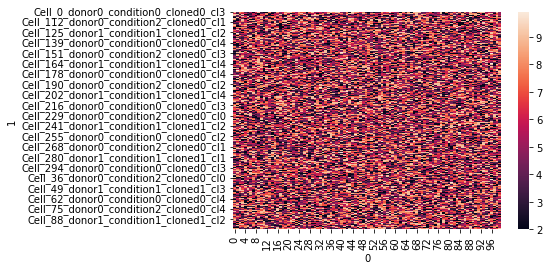

In [28]:
sns.heatmap(np.log2(all_coverage_df))

## Create variant-by-cell matrix for each variant 

In [31]:
ref_df.head()

,pos,ref
0_G,0,G
1_A,1,A
2_T,2,T
3_C,3,C
4_A,4,A


In [37]:
all_nt_pileup[(0,'A')]

,0,1,2,3,4,5
0,93,Cell_0_donor0_condition0_cloned0_cl3,2,37,2.0,37
1,39,Cell_0_donor0_condition0_cloned0_cl3,1,37,1.0,37
2,76,Cell_0_donor0_condition0_cloned0_cl3,8,37,8.0,37
3,58,Cell_0_donor0_condition0_cloned0_cl3,29,37,35.0,37
4,6,Cell_0_donor0_condition0_cloned0_cl3,33,37,30.0,37
...,...,...,...,...,...,...
19673,94,Cell_299_donor1_condition0_cloned1_cl1,260,37,251.0,37
19674,95,Cell_299_donor1_condition0_cloned1_cl1,3,37,5.0,37
19675,96,Cell_299_donor1_condition0_cloned1_cl1,3,37,5.0,37
19676,97,Cell_299_donor1_condition0_cloned1_cl1,125,37,129.0,37


In [42]:
pd.concat(all_nt_pileup).reset_index().rename({"level_0":"condition","level_1":"nt"}, axis=1).drop("level_2", axis=1) 

,condition,nt,0,1,2,3,4,5
0,0,A,93,Cell_0_donor0_condition0_cloned0_cl3,2,37,2.0,37
1,0,A,39,Cell_0_donor0_condition0_cloned0_cl3,1,37,1.0,37
2,0,A,76,Cell_0_donor0_condition0_cloned0_cl3,8,37,8.0,37
3,0,A,58,Cell_0_donor0_condition0_cloned0_cl3,29,37,35.0,37
4,0,A,6,Cell_0_donor0_condition0_cloned0_cl3,33,37,30.0,37
...,...,...,...,...,...,...,...,...
222670,2,T,78,Cell_299_donor1_condition2_cloned1_cl0,14,37,18.0,37
222671,2,T,83,Cell_299_donor1_condition2_cloned1_cl0,17,37,15.0,37
222672,2,T,86,Cell_299_donor1_condition2_cloned1_cl0,133,37,122.0,37
222673,2,T,93,Cell_299_donor1_condition2_cloned1_cl0,64,37,64.0,37


## Calculate AF

In [43]:
all_nt_df = pd.concat(all_nt_pileup).reset_index().rename({"level_0":"condition","level_1":"nt"}, axis=1).drop("level_2", axis=1)
all_nt_df["coverage"] = all_nt_df[2] + all_nt_df[4]
all_nt_df["af"] = all_nt_df.apply(lambda x: x["coverage"]/all_coverage_df.loc[x[1], x[0]]  ,axis=1)
all_nt_df["Variant"]  = all_nt_df.apply(lambda x: f"{x[0]}>{x['nt']}", axis=1)
all_nt_df = all_nt_df.pivot(index=1,columns="Variant", values="af")
all_nt_df = all_nt_df.fillna(0)
all_nt_df

1,Cell_0_donor0_condition0_cloned0_cl3,Cell_0_donor0_condition1_cloned0_cl4,Cell_0_donor0_condition2_cloned0_cl2,Cell_0_donor1_condition0_cloned1_cl2,Cell_0_donor1_condition1_cloned1_cl1,Cell_0_donor1_condition2_cloned1_cl3,Cell_100_donor0_condition0_cloned0_cl3,Cell_100_donor0_condition1_cloned0_cl2,Cell_100_donor0_condition2_cloned0_cl2,Cell_100_donor1_condition0_cloned1_cl3,...,Cell_99_donor0_condition2_cloned0_cl1,Cell_99_donor1_condition0_cloned1_cl2,Cell_99_donor1_condition1_cloned1_cl3,Cell_99_donor1_condition2_cloned1_cl0,Cell_9_donor0_condition0_cloned0_cl4,Cell_9_donor0_condition1_cloned0_cl4,Cell_9_donor0_condition2_cloned0_cl0,Cell_9_donor1_condition0_cloned1_cl1,Cell_9_donor1_condition1_cloned1_cl4,Cell_9_donor1_condition2_cloned1_cl1
Variant,,,,,,,,,,,,,,,,,,,,,
0>A,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
0>C,1.0,0.996094,1.0,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.000000,1.0,1.0,1.000000,1.0,0.996094,1.0,1.0,1.0,1.0
0>G,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.003906,0.0,0.0,0.0,0.0
0>T,0.0,0.003906,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
10>A,0.0,0.000000,0.0,0.001953,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.003906,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99>T,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
9>A,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
9>C,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,0.998047,1.0,1.0,...,0.996094,1.0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0


## Plot all variants (ref and alt)

<AxesSubplot:xlabel='1', ylabel='Variant'>

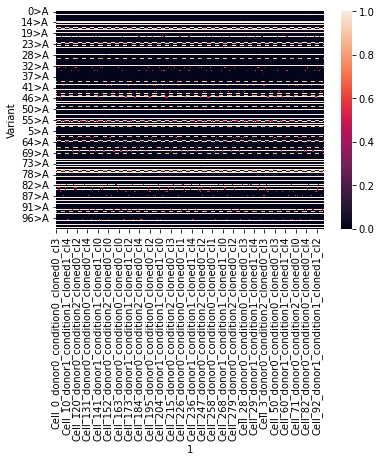

In [45]:
sns.clustermap(all_nt_df)

## Plot variants from clones

In [59]:
clone_vars_df["id"] = clone_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
don_vars_df["id"] = don_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
vars_of_interest = pd.concat([clone_vars_df.set_index("id"),don_vars_df.set_index("id")], axis=0)
vars_of_interest = vars_of_interest[["donor", "clone"]]
vars_of_interest

,donor,clone
id,,
67>C,0,d0_cl0
55>C,0,d0_cl0
92>T,0,d0_cl1
68>G,0,d0_cl1
42>T,0,d0_cl2
40>A,0,d0_cl3
86>G,0,d0_cl3
1>C,0,d0_cl4
34>C,0,d0_cl4


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


dat_type {'donor': 'categorical', 'condition': 'categorical', 'clone': 'categorical'}
categorical
categorical
categorical
dat_type {'donor': 'categorical', 'clone': 'categorical'}
categorical
categorical


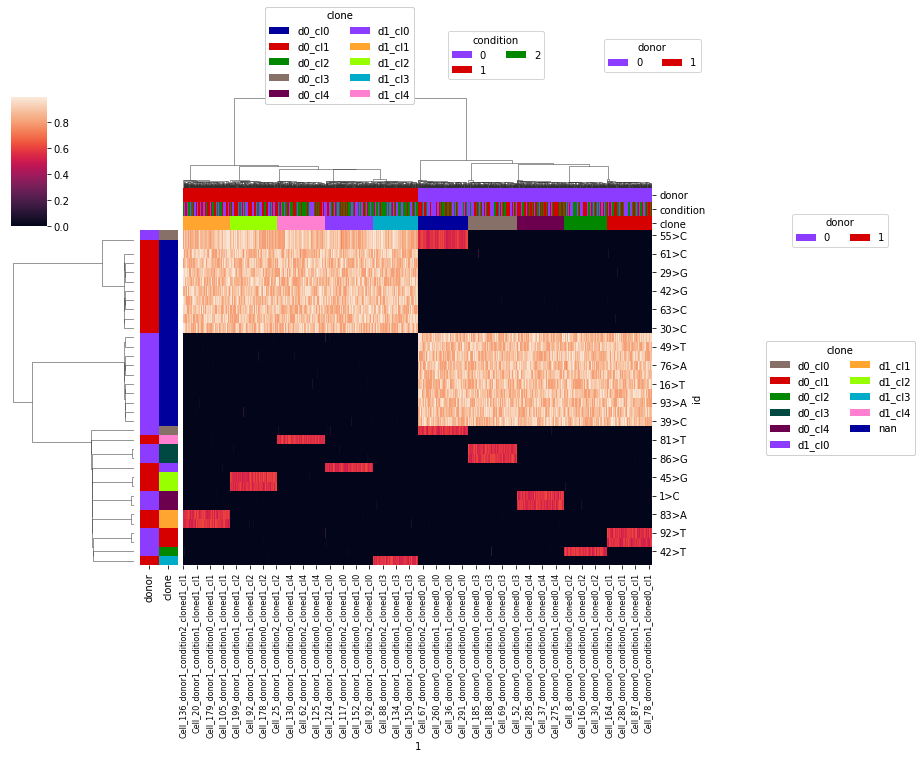

In [71]:
ch.plot_cluster(all_nt_df.loc[vars_of_interest.index],row_meta=vars_of_interest.astype(str),
                col_meta = all_cells_df.astype(str))
plt.savefig(join(curr_outdir, "af.png"))